In [1]:
from models.wmf import WMF
from data.data_transforming import IDEncoder
from evaluation.evaluator import Evaluator
from prediction.predict import predict
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns

In [2]:
model_data = torch.load('./model_files/wmf_model.pth')
user_encoder = model_data["user_encoder"]
track_encoder = model_data["track_encoder"]
config = model_data["model_config"]
model = WMF(
    n_users=len(user_encoder),
    n_items=len(track_encoder),
    embedding_dim=config["embedding_dim"],
    dropout_rate=config["dropout_rate"],
    bias=config["bias"],
    sigmoid=config["sigmoid"],
    init=False
)
model.load_state_dict(model_data["model_state_dict"])

<All keys matched successfully>

In [3]:
sessions_val_df = pd.read_json('data_files/val_sessions.jsonl', lines=True)

In [4]:
sessions_val_df["user_id"] = user_encoder.encode(sessions_val_df["user_id"].tolist())
sessions_val_df["track_id"] = track_encoder.encode(sessions_val_df["track_id"].tolist())

In [5]:
random_ids = np.random.choice(len(user_encoder), size=50, replace=False)
users = np.array(random_ids)
tracks = np.arange(len(track_encoder))
df = pd.DataFrame(
    product(users, tracks),
    columns=['user_id', 'track_id']
)

sessions_val_df = df.merge(
    sessions_val_df[['user_id', 'track_id', 'score']],
    on=['user_id', 'track_id'], 
    how='left'
).fillna(0)

In [6]:
val_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_val_df['user_id'].values),
    torch.LongTensor(sessions_val_df['track_id'].values),
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
sessions_val_df['score_pred'] = predict(model, val_loader, device)

In [8]:
k_list = [5, 10, 30, 40, 50]
evaluator = Evaluator(k_list, 2.0)

In [9]:
metrics = evaluator.evaluate(sessions_val_df)

In [10]:
metrics_df = pd.DataFrame()
for k in k_list:
    metrics_df[f'NDCG@{k}'] = metrics[f'NDCG@{k}']
    metrics_df[f'Precision@{k}'] = metrics[f'Precision@{k}']
    metrics_df[f'Recall@{k}'] = metrics[f'Recall@{k}']
display(metrics_df)

,NDCG@5,Precision@5,Recall@5,NDCG@10,Precision@10,Recall@10,NDCG@30,Precision@30,Recall@30,NDCG@40,Precision@40,Recall@40,NDCG@50,Precision@50,Recall@50
user_id,,,,,,,,,,,,,,,
28,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000
121,0.267229,0.2,0.017241,0.189071,0.1,0.017241,0.143277,0.066667,0.034483,0.145819,0.075,0.051724,0.142129,0.08,0.068966
143,0.105725,0.0,0.000000,0.101913,0.0,0.000000,0.058902,0.000000,0.000000,0.050073,0.000,0.000000,0.049945,0.00,0.000000
368,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.010952,0.00,0.000000
649,0.184410,0.0,0.000000,0.142495,0.0,0.000000,0.085942,0.000000,0.000000,0.109095,0.025,0.200000,0.108261,0.02,0.200000
710,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.021124,0.000,0.000000,0.019340,0.00,0.000000
736,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.020817,0.000000,0.000000,0.017580,0.000,0.000000,0.015345,0.00,0.000000
746,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.010282,0.000000,0.000000,0.008650,0.000,0.000000,0.013978,0.00,0.000000
748,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00,0.000000


In [14]:
for k in k_list:
    print(f'NDCG@{k} mean and std dev')
    print(metrics[f'NDCG@{k}_mean'] * 100)
    print(metrics[f'NDCG@{k}_std'] * 100)
    print(f'Precision@{k} mean and std dev')
    print(metrics[f'Precision@{k}_mean'] * 100)
    print(metrics[f'Precision@{k}_std'] * 100)
    print(f'Recall@{k} mean and std dev')
    print(metrics[f'Recall@{k}_mean'] * 100)
    print(metrics[f'Recall@{k}_std'] * 100)   

NDCG@5 mean and std dev
5.283032198522168
11.412501479011217
Precision@5 mean and std dev
3.6000000000000005
11.911236334671905
Recall@5 mean and std dev
0.31482463896257
1.064341709036208
NDCG@10 mean and std dev
5.375284953093402
10.61249537060132
Precision@10 mean and std dev
3.4000000000000004
11.177601509724887
Recall@10 mean and std dev
0.5994384601007814
1.6890569086594025
NDCG@30 mean and std dev
6.611827704158856
13.067396524517669
Precision@30 mean and std dev
4.933333333333334
15.739373912467505
Recall@30 mean and std dev
2.7438998512001036
8.172698358990731
NDCG@40 mean and std dev
7.031887543778631
13.88785124658298
Precision@40 mean and std dev
5.0
15.386185163241436
Recall@40 mean and std dev
4.03045369591627
10.63814727265727
NDCG@50 mean and std dev
7.340948461853857
14.579465307733885
Precision@50 mean and std dev
4.76
14.640675795710461
Recall@50 mean and std dev
4.761667223767728
12.705711906104987


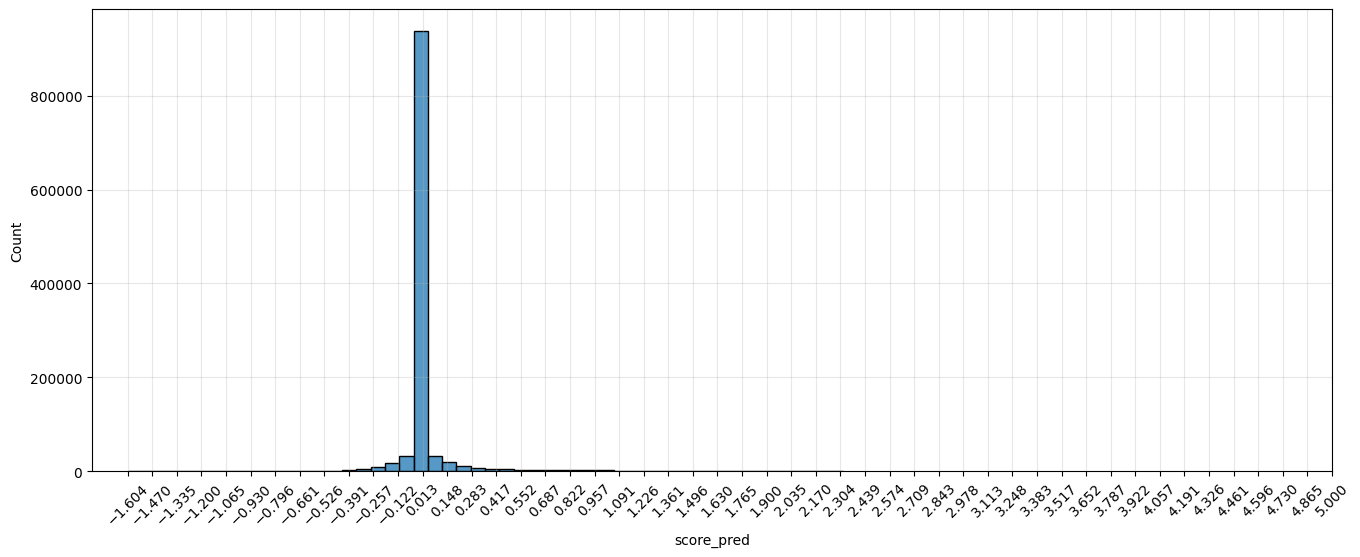

In [15]:
zoom_max = 5.0
ticks = 50
filtered_df = sessions_val_df[sessions_val_df['score_pred'] < zoom_max]

plt.figure(figsize=(16, 6))
sns.histplot(data=filtered_df, x='score_pred', bins=50)
plt.grid(True, alpha=0.3)

x_min = filtered_df['score_pred'].min()
x_max = zoom_max
x_ticks = np.linspace(x_min, x_max, ticks)
plt.xticks(x_ticks, rotation=45)

plt.show()

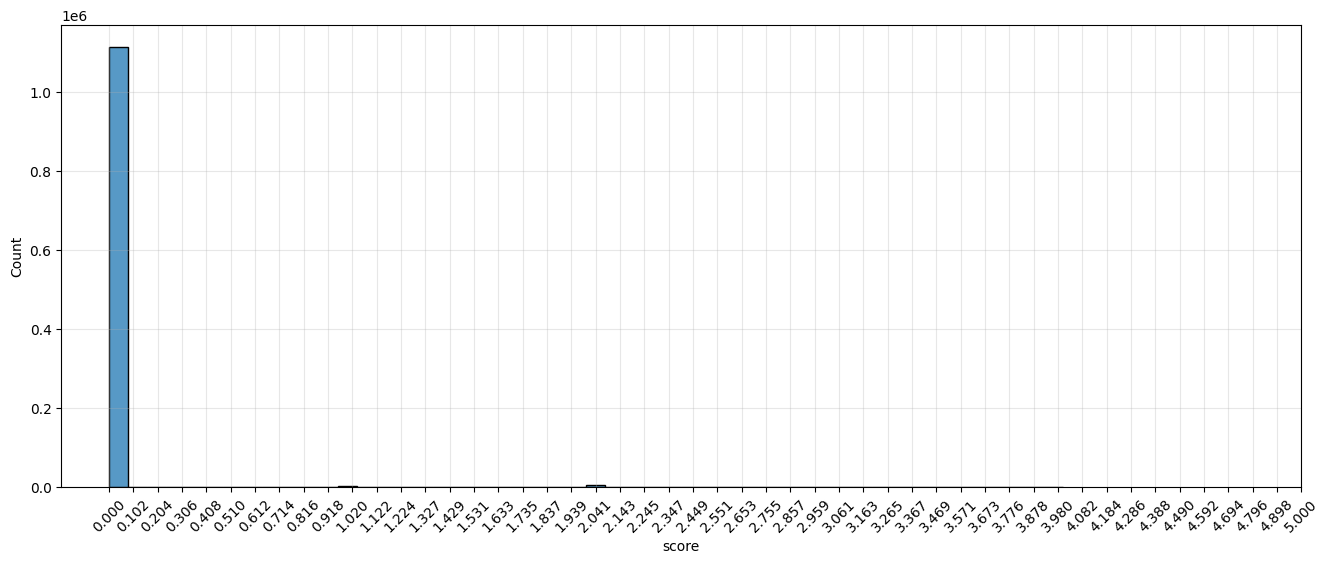

In [16]:
zoom_max = 5.0
ticks = 50
filtered_df = sessions_val_df[sessions_val_df['score'] < zoom_max]

plt.figure(figsize=(16, 6))
sns.histplot(data=filtered_df, x='score', bins=50)
plt.grid(True, alpha=0.3)

x_min = filtered_df['score'].min()
x_max = zoom_max
x_ticks = np.linspace(x_min, x_max, ticks)
plt.xticks(x_ticks, rotation=45)

plt.show()